# ICW2 - Attention Models

Author: Fabian Ketzler 549108



##### WICHTIG: Das Notebook bitte mit einem lokalen Jupyter-Server betrachten, GitLab stellt den Inhalt nicht richtig dar.

# 1 Motivation

Die Motivation eine Ausarbeitung zum Thema Attention Models anzufertigen, basiert vor allem auf dem Artikel [The fall of RNN / LSTM](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0?gi=6bb953ae3b23) während der Recherche zum [ICW1](https://gitlab.com/fabian.ket/icw1) und [Forschungsprojekt A](https://gitlab.com/fabian.ket/forscha). Dieser sagte aus, Zitat: "Now it is time to drop them!". Gemeint sind hier die "normalen" RNN-Encoder-Decoder basierend auf LSTMs oder GRUs. Da diese Aussage recht reißerisch ist, wurde es interessant zu prüfen wie hoch der Wahrheitsgehalt ist und vor allem was denn überhaupt genau diese Attention Models sind, wie sie verwendet werden und was ihre Intention ist. Die Möglichkeit das [NeuroRace Projekt](https://gitlab.com/NeuroRace) noch weiter zu verbessern sollte genutzt werden. Dafür war es jedoch erst einmal notwendig die Theorie hinter Attention Models zu erarbeiten und zu verstehen. Genau das soll auch die Motivation für diese Ausarbeitung sein, die Theorie von Attention Models zu erarbeiten und erste kleine Implementierungen im reinem [Tensorflow](https://www.tensorflow.org/) zu programmieren. Der Grund für die reine Tensorflow-Implementierung ist, dass so alle einzelnen Schritte von Attention Models selbst implementiert werden müssen, anstatt bei APIs mit höherer Abstraktion wie z.B. [Keras](https://keras.io/), welche einem schon viele Einzelheiten abnehmen und vereinfachen. Jedoch geht es hier nicht um eine "serienreife" Implementierung, sondern darum das eigene Wissen auszubauen. Genau deshalb die Tensorflow-Implementierung, so muss man sich auf alle Aspekte von Attetion Models konzentrieren und sich mit diesen auseinander setzen. Tensorflow wird dafür verwendet die Gradientenberechnung zu übernehmen.

# 2 Einleitung

## 2.1 Warum Attention Models

Zum Lösen von vielen verschiedenen Problemen, welche auf sequenzielle Daten beruhen, reichen einfach LSTM / GRU basierte Lösungen nicht aus. Das Problem bei manchen Aufgabe ist es, dass die Eingabesequenz kürzer oder länger als die Ausgabesequenz ist und somit ein direktes verknüpfen von aktuellem RNN-Output mit dem dazugehörigen Element der Ausgabesequenz nicht möglich ist. Für solche Probleme wurden sich Encoder-Decoder-Architekturen erdacht. Diese ermöglichen es sequenzielle Probleme mit unterschiedlichen Ein-/ und Ausgabesequenzlängen zu lösen. Diese Architekturen weisen jedoch ein großes Problem auf, dazu siehe erst einmal folgendes Bild:

[[Ng18b]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-intuition-RDXpX)

<img src="images/diag_endecoder.png" alt="" title="" width="800" height="" />
<p style="text-align: center">Abbildung 1: RNN-Encoder-Decoder</p>

Nachdem der rot markierte Encoder die Eingabesequenz verarbeitet hat, wird die Eingabesequenz nur noch durch einen einzelnen Hidden-State-Vektor repräsentiert. Die vorherigen States des Encoders können nicht direkt verwendet werden und gehen damit "verloren". Sie sind nicht vollständig verloren, da sie ja einen Einfluss auf den letzten State des Encoders haben, jedoch kann nicht direkt mit den vorherigen States des Encoders gearbeitet werden. Ein direktes verwenden dieser States würde sich jedoch positiv auf die Leistung des Decoders auswirken, da sie so jeden State des Decoder aktiv beeinflussen könnten. Eine weitere Möglichkeit die Encoder-Decoder-Architektur zu implementieren wäre es, den letzten Hidden-State des Encoders als Eingabe für jeden Decoder-State zu verwerden. Die erste Abbildung stellt die ursprügliche, von Google 2014 vorgestellte Encoder-Decoder-Architektur dar ["Sequence to Sequence Learning with Neural Networks"](https://arxiv.org/abs/1409.3215). In der folgenden Abbildung wird die andere Möglichkeit der Implementierung dargestellt, hier ist es dem Decoder möglich noch dazu einen eigenen unabhängigen Hidden-State zu verwalten.

[[Ng18b]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-intuition-RDXpX)

<img src="images/diag_endecoder_h_all.png" alt="" title="" width="800" height="" />
<p style="text-align: center">Abbildung 2: RNN-Encoder-Decoder mit letztem Hidden-State an alle Decoder-States</p>

In der Implementierung ist ein GRU-Encoder-Decoder basierend auf der zweiten Abbildung implementiert.

Um dieses Problem zu lösen, wurden sich Attention Models erdacht. Attention Models sorgen dafür, dass die Hidden-States des Encoders nicht einfach verworfen, sondern mit dem Decoder verknüpft werden können. Die Hidden-States des Encoders werden durch einen so genannten Kontextvektor repräsentiert. Dem Decoder wird dann zu jedem Zeitpunkt ein aktueller Kontext, durch den Kontextvektor, zur Verfügung gestellt. Das neuronale Netz des Kontextes sagt somit aus, wie viel Aufmerksamkeit der Decoder, gegeben seinem vorherigen Hidden-State $s^{<t-1>}$ und den Hidden-States des Encoders $h$, für die vorhersage von $\hat{y}^{<t>}$ den einzelnen $x^{<t'>}$ schenken sollte.

* t = $T_y$ $\hat =$ Timesteps / Sequenzlänge des Decoders
* t' = $T_x$ $\hat =$ Timesteps / Sequenzlänge des Encoders

Ein Nachteil bei der Berechnung des Kontextes soll hier schon einmal genannt werden und zwar, dass da die Berechnung alle Hidden-States des Encoders verwendet, es zu einer Komplexität von O($n^2$) kommen kann. Das jedoch natürlich nur wenn t = t' ist.

[[Ng18b]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-intuition-RDXpX)

## 2.2 Einsatzgebiete

Überall wo sequenzielle Daten anfallen können Sequence Learning Models verwendet werden. Attention ist hierbei eine Erweiterung der etablierten neuronalen Netze für sequenzielles Lernen. Die Einsatzgebiete sind daher Bereiche bei denen auch sequenzielle Daten anfallen wie z.B.:

* Natural language processing (NLP)
* Neural machine translation (NMT)
* Image captioning
* Video analyses
* Sound creation
* usw.

# 3 Grundlagen

## 3.1 Notation der Daten

Folgend die verwendete Notation der Daten, am Beispiel der Namenserkennung innerhalb eines Satzes. Die Namenserkennung wird verwendet, da sich die einzelnen Vektoren mit der der Reber Grammatik gleichen, jedoch einfacher zu verstehen sind. Sie ist einfacher zu verstehen, weil mit Wörtern und nicht nur mit einzelnen Zeichen gearbeitet wird.

Der Satz lautet: __Harry Potter and Hermine Granger invented a new spell__. Dieser Satz ist das erste Trainingsbeispiel. Ein Satz ist eine Sequenz von einzelnen Wörtern. 

[[Ng18a]](https://www.coursera.org/lecture/nlp-sequence-models/notation-aJT8i)

|    |       |        |     |         |         |          |   |     |       | 
| -- | ----- | ------ | --- | ------- | ------- | -------- | - | --- | ----- |
| x: | Harry | Potter | and | Hermine | Granger | invented | a | new | spell |
|    | $x^{<1>}$ | $x^{<2>}$ | $x^{<3>}$ | ... | $x^{<t>}$ | | ... | | $x^{<9>}$ | 


$t' = 9$  $\hat{=}$ Länge der Sequenz $x^{(i)}$

$x^{(i)<t>}$ hierbei entspricht i $\hat{=}$ dem i'te Trainingsbeispiel und t' $\hat{=}$ dem t' ten Element der Sequenz.

Das Label zum Trainingssatz zur Namenserkennung hat an den einzelnen Stellen im Satz, an dem ein Name vorkommt eine 1 stehen und sieht wie folgt aus:

|    |       |        |     |         |         |          |   |     |       | 
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| y: | 1 | 1 | 0 | 1 | 1 | 0 | 0 | 0 | 0 |
|    | $y^{<1>}$ | $y^{<2>}$ | $y^{<3>}$ | ... | $y^{<t>}$ | | ... | | $y^{<9>}$ | 

$t = 9$  $\hat{=}$ Länge der Sequenz $y^{(i)}$

$t^{(i)}$ $\hat{=}$ Sequenzlänge des i'ten Trainingsbeispiels (Sätze sind nicht immer gleich lang).

Ein Trainingsbeispiel $x$ besteht also aus $x^{<1>}$, $x^{<2>}$, ..., $x^{<t'>}$. Wobei hier $x^{<t'>}$ ein Wort des Satzes darstellt. Die Wörter selber können dann als ein Vokabular dargestellt werden. Dies bedeutet, dass ein Wort $x^{<t'>}$ repräsentiert wird durch:

[[Ng18a]](https://www.coursera.org/lecture/nlp-sequence-models/notation-aJT8i)

$$Vokabular \; \vec{v} = \begin{bmatrix}
  a \\
  aaron \\
  \vdots \\
  and \\
  \vdots \\
  harry \\
  \vdots \\
  potter \\
  \vdots \\
  zulu \\
\end{bmatrix}
\; \; \;
harry \; \hat{=} \; x^{<1>} \; = \;
\begin{bmatrix}
  0 \\
  0 \\
  \vdots \\
  0 \\
  \vdots \\
  1 \\
  \vdots \\
  0 \\
  \vdots \\
  0 \\
\end{bmatrix}$$

Der erste Vektor zeigt das gesamte Vokabular auf, enthält also jedes einzelne Wort das vorkommen kann. Jedes einzelne Wort in  der Sequenz wird dann als ein One-Hot codierter Vokabularvektor dargestellt. Nur an der Stelle des Vektor, die die Position des Wortes im gesamten Vokabular darstellt steht eine $1$. Im obrigen Beispiel steht nur an der Stelle $harry$ eine $1$, da $x^{<1>}$ das Wort $harry$ ist.

[[Ng18a]](https://www.coursera.org/lecture/nlp-sequence-models/notation-aJT8i)


Bei der $Reber \; Grammatik$ besteht das Vokabular aus nur $7$ verschiedenen Zeichen, daher ist der Vokabularvektor auch nur 7-Dimensional $\vec{v} \in R^7$.
<br />

$$Vokabular \; \vec{v} \; \hat{=} \; \begin{bmatrix} B \\ T \\ S \\ X \\ P \\ V \\ E\\ \end{bmatrix}$$

Wichtige Notationen der Implementierung wie auch in dieser Arbeit soll hier noch einmal zusammengefasst dargestellt werden. Da es keine offizielle Notation gibt und eine Zusammenfassung nicht schaden kann. Es ist jedoch nur ein kleiner Einschub, damit die Indizierung der Gewichtungen in der Implementierung ersichtlich wird:

* Der erster Index der z.B. Gewichtungsmatrix $W_{xh}$ bedeutet, dass die Matrix mit einer Eingabe $x$ multipliziert wird und einen Hidden-State ergibt, also ein $h$.
* Hidden-States des Encoders werden immer mit $h$ gekennzeichnet.
* Hidden-States des Decoders werden immer mit $s$ gekennzeichnet.
* Indizierungen in der Implementierung wie z.B. s_tm1 bedeuten, dass hier der vorherige Decoder-State gespeichert wurde, also $s^{<t-1>}$, s_t $m$inus 1
* Etwas mit einem hochgestelltem $<n>$ bedeutet, dass es sich um den Timestep n handelt

## 3.2 Attention Models

### 3.2.1 Attention Layer

Das erste Mal vorgestellt wurde Attention im 2014 veröffentlichtem Paper "Neural Machine Translation by Jointly Learning to Align and Translate" [\[Bah14\]](https://arxiv.org/abs/1409.0473). Hier wurde noch nicht von Attention Models gesprochen, jedoch schon von Attention. Wie auch z.B. bei der GRU erfolgte die Benennung erst später.

Attention Models nutzen vom Prinzip her genau das, was man sich unter Aufmerksamkeit vorstellt. Anstatt die Aufmerksamkeit eines Models immer auf evtl. alle Elemente einer Sequenz zu richten, wird diese nur auf einen Teil der Elemente gerichtet. Auf welche Elemente genau muss mit Hilfe des Trainings gelernt werden. Die Intuition hierbei ist, das auch der Mensch, beim z.B. Übersetzen eines Textes nicht immer erst den gesamten Ausgangstext liest und diesen sich einprägt und dann übersetzt, sondern schon nach einigen Wörtern erste Übersetzungsschritte durchgeführt werden. Vorherige Modelle des Neural Machine Translations nutzten meist n-zu-m RNN-Encoder-Decoder um Übersetzungen durchzuführen. Diese Model-Art, basierend auf z.B. LSTM-Zellen, ist bei der Problemlösung von Übersetzungen notwendig, da ein englisher Satz in einen deutschen Satz übersetzt werden muss, welcher weniger oder auch mehr Wörter aufweisen kann. Genau deshalb müssen hier n-zu-m Encoder-Decoder verwendet werden. Wie bereits im Abschnitte 2.1 beschrieben wird beim Encoder-Decoder der Eingabesatz jedoch nach dem Encodieren nur durch einen einzelnen State-Vektor repräsentiert. Attention-Models nutzen nun alle States eines Encoders, wenn das Attention-Model auf diesem Prinzip basiert. Später wird noch eine Attention-Architektur vorgestellt, welche keine RNN-Komponenten mehr ausweist, jetzt jedoch wird sich erst einmal auf das grundlegende Model [\[Bah14\]](https://arxiv.org/abs/1409.0473) konzentriert und dieses nutzt RNN-Komponenten.

[[Ng18c]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)

<img src="images/diag_attention.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 3: Attention-Model</p>

Grundlegend nutzen Attention-Models RNN-Encoder-Decoder und können als Layer zwischen dem Encoder und Decoder verstanden werden. Wie der oberen Abbildung zu entnehmen, werden durch den Encoder $t'$ viele Hidden-States erstellt. Diese States werden nun von der Attention-Zelle (in dieser Arbeit so betitelt, dies ist nicht die offizielle Bezeichnung dafür) verwendet um den jeweiligen Attention-Kontext für die einzelnen Decoder States zu berechnen. Es müssen also $t$ viele Attention-Kontexte berechnet werden. Der Kontext wird in der Abbildung durch die einzelnen $C^{<t>}$ dargestellt. Die Attention-Zelle nutzt also alle Hidden-States des Encoders und den vorherigen Hidden-State des Decoders um den Kontext für den jeweiligen State des Decoders zu berechnen. Evtl. in Verwendung befindliche Peephole-Connections im Decoder wurden der Übersicht wegen nicht in der Abbildung dargestellt. Der Vorteil dieser Kontexte ist es, dass entgegen dem normalen Encoder-Decoder-Prinzip, alle Hidden-States des Encoders direkt in Verwendung sind und nicht nur der finale Hidden-State. Der Attention-Layer dient also dazu, beim jeweiligen vorherigen Hidden-State des Decoders die Aufmerksamkeit auf die wichtigen Hidden-States des Encoders zu lenken. Genau so wie es der Mensch beim Übersetzen auch machen würde, man hat den gesamten Ausgangstext vor sich, konzentriert sich beim übersetzen jedoch auf den Teil des Ausgangstextes welcher beim aktuellen Übersetztungsschritt wichtig ist.

[[Ng18c]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)

Als RNN-Zelle werden in der Implementierung wie auch in den Abbildungen mit GRU-Zellen gearbeitet da diese nur einen einzelnen Hidden-State haben und somit die Berechnungen und Darstellungen etwas reduzieren.

Wie eine Attention-Zelle einen Kontext berechnet, soll nun Schritt für Schritt erklärt werden. Hierbei wird immer der Teil der Zelle scharf dargestellt, welcher gerade erklärt wird, der Rest der Zelle wird unscharf dargestellt.

Zuerst wird immer die Abbildung dargestellt und unterhalb der Abbildung kann dann die dazugehörige Beschreibung gelesen werden.

Die Attention-Zelle baut sich folgendermaßen auf:

<img style="float: left; margin-left: 5em; margin-right: 2em;" src="images/diag_attention_cell_elementwise.png" alt="" title="" width="100" height="" /> <p style="margin-top: 1.5em">Als blaue Kreise sind elementweise Operationen gekennzeichnet, + Addieren bzw. X Multiplizieren</p>

<img src="images/diag_attention_cell_full.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 4: Attention-Zelle</p>

Zuerst soll die komplette Zelle betrachtet werden. Diese dient dazu, einen Überblick über den ungefähren Ablauf einer Attention-Zelle zu erhalten. Zu erkennen ist, dass eine Attention-Zelle aus vier Einzelschritten besteht:

1. dem Attention-Zellen-Input
2. Berechnung der Attention-Energien
3. Berechnung der Attention-Faktoren
4. Berechnung des Kontextes

Zum besseren Verständnis, werden die einzelnen Attention-Schritte anhand eines kleinen Rechenbeispiels durchgearbeitet und dargestellt. Wobei die einzelnen Elemente der Sequenz durch die einzelnen Zeilen der $h$ Matrix repräsentiert werden. Die $h$ Matrix entspricht hierbei den einzelnen Hidden-States eines Encoder-Durchlaufs. Das bedeutet, im Rechenbeispiel wird sich einzig und allein auf die einzelnen Attetion-Rechenschritte konzentriert und nicht auch noch auf die RNN-Berechnungen.

<!--
$$h = 
\left(\begin{array}{cc} 
0.1 & 0.2 & 0.3 \\ 
0.4 & 0.5 & 0.6 \\
0.7 & 0.8 & 0.9
\end{array}\right)
$$
-->

[\[Bli16\]](https://lab.heuritech.com/attention-mechanism)

In [1]:
import numpy as np

# Encoder Hidden-State Matrix
h = np.asarray([[-0.43,  0.93, -0.01],
                [ 0.73, -0.98, -0.23],
                [ 0.12,  0.34,  0.99],
                [-0.87, -0.52, -0.73]])

# vorherige Decoder-State
s_tm1 = np.asarray([[-0.74, 0.94, 0.47]])


print(h.shape)
print(s_tm1.shape)

(4, 3)
(1, 3)


* $h^{<1>} \hat{=}$ der ersten Zeile der $h$ Matrix
* $h^{<2>} \hat{=}$ der zweiten Zeile der $h$ Matrix
* usw.

### 1. Attention-Zellen-Input

<img src="images/diag_attention_cell_inputs.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 5: Eingabe Attention-Zelle</p>

Die Zelle erhält als Eingabe den Hidden-State $s^{<t-1>}$ des Decoders und die einzelnen Elemente der Sequenz $h$ bestehend aus $t'$ vielen Elementen. Wie bereits beschrieben ist $h$ in der Implementierung und auch in der Abbildung eine Sequenz der Hidden-States des Encoders. Der Vorteil an dieser Berechnungsgrundlage für den Kontext ist es, das eben alle Hidden-States des Encoders auf jeden Kontext Einfluss haben und nicht nur der finale Hidden-State. Dieser erweiterte Input ist es, der die Grundlage des Attention-Models bildet. Genau diese Erweiterung sorgt dafür, also die Verwendung von allem Vorherigen, dass so etwas wie Aufmerksamkeit überhaupt im Model verwendet werden kann.

[[Bli16](https://lab.heuritech.com/attention-mechanism), [Ng18c](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)]

### 2. Berechnung Attention-Energie

<img src="images/diag_attention_cell_tanh.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 6: Attention-Energie</p>

Die Attention-Energie, hier bezeichnet mit $e^{<t'>}$, wird mit Hilfe eines kleinen geteilten neuronalen Netzwerk berechnet. Die Bezeichnung Energie ist hier nur im übertragenen Sinn zu verstehen. Sie sagt jedoch aus wie stark der jeweilige $h^{<t'>}$ State Einfluss auf den aktuellen Kontext hat. Das Attention-Energie-Netz erhält als Eingabe den jeweiligen Hidden-State des Encoders und den aktuellen vorherigen Hidden-State des Decoders. Dieses neuronale Netz oder besser die Gewichtungen des Netzes werden wie z.B. auch bei CNNs von allen Eingaben in dieser Schicht geteilt.

[[Bli16](https://lab.heuritech.com/attention-mechanism), [Ng18c](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)]

Die folgende Abbildung soll die Berechnung der Energie verdeutlichen:

<img src="images/diag_attention_e.png" alt="" title="" width="400" height="" />
<p style="text-align: center">Abbildung 7: neuronales Netz zur Berechnung der Attention-Energie</p>

In der Literatur und auch in dieser Abbildung werden die internen Attention-Zellen Eigenschaften immer mit einem hochstehenden $<t, t'>$ gekennzeichnet. Zu lesen wie folgt: $e^{<t, t'>}$ ist die Attention-Energie für den $t$'ten Decoder-State des $t'$'ten Encoder-States. Der Übersicht wegen und auch aufgrund der Tatsache, dass in diesem Rechenbeispiel nur von einer einzelnen Attention-Zelle ausgegangen wird, wurden die $t$'s weggelassen.

Die allgemeine Formel zur Berechnung der Attention-Energie $e^{<t, t'>}$ sieht folgendermaßen aus:

$$ e^{<t, t'>} = tanh(s^{<t-1>} * W_{se} + h^{t'} * U_{he}) * \vec v$$

Durch die Matrixmultiplikation mit dem Vektor $\vec v$ (Shape [n, 1]) ist das Ergebnis ein Skalar und somit wird ein einfaches Skalarprodukt berechnet. Alle Matrizen und auch der Vektor $\vec v$ sind Gewichtungsmatrizen und können durch den Trainingsprozess gelernt werden. Das Rechenbeispiel benötigt nun also diese Gewichtungen um die Attetion-Energie zu berechnen:

In [3]:
W_se = np.random.rand(3, 3)
U_he = np.random.rand(3, 3)
v_e  = np.random.rand(3, 1)

print(W_se.shape)
print(U_he.shape)
print(v_e.shape)

(3, 3)
(3, 3)
(3, 1)


Mit Hilfe dieser Gewichtungen können nun die kompletten Attention-Energien auf einmal vektorisiert berechnet werden. Hierfür ist nur noch die tanh Funktion notwendig:

In [4]:
def tanh(x):
    return 1.0 - (2 / (np.exp(2*x) + 1.0))

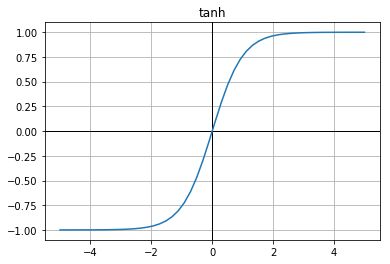

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-5, 5)

plt.grid(True)
plt.title("tanh")
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')

plt.plot(x, tanh(x))

In [6]:
mul = np.matmul

e = mul( tanh( mul(s_tm1, W_se) + mul(h, U_he) ), v_e)

print(e.shape)

(4, 1)


Wichtig ist hierbei die Shape der Attention-Energien anzumerken. Zu jedem Hidden-State des Encoders gibt eine einzelne Zahl die Energie des States auf den Kontext an.

### 3. Attention-Faktoren

<img src="images/diag_attention_cell_softmax.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 8: Attention-Faktoren</p>

Auf Basis der Attetion-Energie können nun die einzelnen Attention-Faktoren oder Skalierungswerte berechnet werden. Hierfür werden die einzelnen Energien mit einer Softmax-Funktion verknüpft. Zu beachten ist, dass nur die einzelnen $e^{<t'>}$ Werte mit der Softmax-Funktion verknüpft werden, die einzelnen $h^{<t'>}$ Werte gehen in der Abbildung hinter der Softmax-Funktion vorbei und werden hier nicht verwendet.

[[Bli16](https://lab.heuritech.com/attention-mechanism), [Ng18c](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)]

Die allgemeine Formel zur Berechnung der Attention-Faktoren $\alpha$ ist die folgende:

$$ \alpha^{<t, t'>} = {exp(e^{<t, t'>}) \over \sum_{t'} exp(e^{<t, t'>})} \; \; (Softmax)$$

Wobei durch die Verwendung der Softmax-Funktion gegeben ist das:

$$\sum_{t'} \alpha^{<t, t'>} = 1 $$ 

Somit hat eine hohe Attention-Energie zur Folge, dass auch ein hoher Attention-Faktor von der Softmax-Funktion beim jeweiligen $t'$ ausgegeben wird. Aufgrund der Softmax-Funktion können die einzelnen Faktoren als eine diskrete Wahrscheinlichkeitsverteilung angesehen werden. Diese sagt aus wie wahrscheinlich $\alpha^{<t, t'>}$ gegeben $s^{<t-1>}$ und $h^{<t'>}$ ist.

$$p(\alpha^{<t, t'>} \mid s^{<t-1>}, h^{<t>})$$

Die $\alpha$-Werte können auch als eine Art Relenvanz gesehen werden welche aussagt wie relevent, also wichtig, dieser Hidden-State für den aktuellen Kontext ist.

Der Grund warum in diesem Schritt auf Softmax gesetzt wird und nicht z.B. auf $argmax$ ist (obwohl argmax schon anders arbeitet, soll hier jetzt jedoch nicht weiter ausgeführt werden), das Softmax differenzierbar ist und somit innerhalb eines neuronalen Netzes verwendet werden kann und somit beim Training des Netzes nicht stört. 

[[Bli16](https://lab.heuritech.com/attention-mechanism), [Ng18c](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)]

Für die weitere Berechnung wird also die Softmax-Funktion benötigt:

In [7]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

Die Attention-Faktoren $\alpha$ können dann einfach über $softmax(e)$ berechnet werden.

[[0.35202511]
 [0.14327254]
 [0.45953202]
 [0.04517033]]
alpha sum is: 1.0
(4, 1)


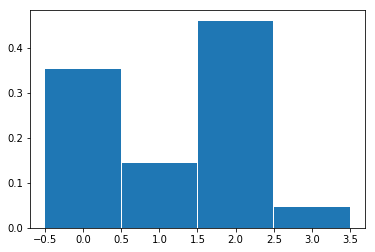

In [8]:
alpha = softmax(e)

plt.bar(range(len(alpha)), height=np.reshape(alpha, len(alpha)), width=0.99)

print(alpha)
print("alpha sum is: {}".format(np.sum(alpha)))
print(alpha.shape)

### 4. Berechung des Kontextes

<img src="images/diag_attention_cell_context.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 9: Attention-Kontext</p>

Auf Basis der $\alpha$-Werte kann nun der aktuelle Decoder-Kontext berechnet werden. Hierfür wird der jeweilige $\alpha$-Wert mit dem dazugehörigen $h^{<t'>}$ elementweise multipliziert und die daraus entstehenden Ergebnisse summiert. Die Quelle [\[Bli16\]](https://lab.heuritech.com/attention-mechanism) spricht hier vom gewichteten arithmetischen Mittel, was jedoch nicht richtig ist da es sich um eine gewichtete Summe handelt, gewichtet durch die einzelnen $\alpha$-Werte. Vermutlich ist jedoch das Richtige gemeint, was nur ungünstig formuliert wurde. Würde man das arithmetische Mittel verwenden, würde dies dem eigentlichen Sinn der $\alpha$-Werte widersprechen, da sie gesehen als diskrete Wahrscheinlichkeitsverteilung die einzelnen Hidden-States des Encoders ja schon auf 1 summieren und nicht noch gemittelt werden müssten. Während des Trainings und der Differenzierung würde die Verwendung des arithmetischen Mittels sich jedoch nur als Faktor über alle Hidden-States auswirken und somit vernachlässigbar sein. Dies wurde auch durch eigene Tests bestätigt. Vom Sinn her muss an dieser Stelle jedoch mit der Summe gearbeitet werden. Genau das wird auch in der folgenden Beispielrechnung durchgeführt.

[[Bli16](https://lab.heuritech.com/attention-mechanism), [Ng18c](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa)]

Die allgemeine Formel zur Berechnung des Kontextes ist die folgende:

$$ C^{<t>} = \sum_{t'}\alpha^{<t, t'>} \odot h^{<t'>} $$

In [10]:
mup = np.multiply

C = np.sum(mup(alpha, h), axis=0, keepdims=True)

print("alpha")
print(alpha)
print()

print("Encoder Hidden-State")
print(h)
print()

print("Current Decoder Context")
print(C)

print("C shape: {}".format(C.shape))

alpha
[[0.35202511]
 [0.14327254]
 [0.45953202]
 [0.04517033]]

Encoder Hidden-State
[[-0.43  0.93 -0.01]
 [ 0.73 -0.98 -0.23]
 [ 0.12  0.34  0.99]
 [-0.87 -0.52 -0.73]]

Current Decoder Context
[[-0.03093618  0.31972858  0.38548943]]
C shape: (1, 3)


Der somit berechnete Kontext enthält Informationen aus allen Elementen der Eingabesequenz, hier die Hidden-States des Encoders. Jedoch wirkt sich jedes Element der Eingabesequenz nur anteilig, basierend auf ihre Attention-Energie, auf den Kontext aus. Genau dies ist es was Attention den Sequence Learning Models hinzufügen wollte und es auch tut. Es bietet die Möglichkeit jedes Zwischenergebnis zu verwenden und das auch dann wenn es sich um ein n-zu-m Problem handel bei dem $t \ne t'$ ist.

<img src="images/diag_alpha_multiply.png" alt="" title="" width="400" height="" />
<p style="text-align: center">Abbildung 10: Berechnung des Attention-Kontextes</p>

Hier noch einmal die Kontextberechnung in einem Kurzdiagramm dargestellt. Die einzelnen $h^{<t'>}$ Vektoren werden mit dem korrespondierenden Attention-Faktor $\alpha^{t'}$ verknüpft und ergeben in Summe den Kontext zum aktuellen Zeitpunkt. Da das Erstellen dieses Diagramms nun einmal etwas Zeit gekostet hat soll es nicht verschwendet und somit verwendet werden und als kleine Ergänzung ist es recht hilfreich.

Es ist ebenso möglich $e^{<t'>}$ nicht auf Basis eines kleinen neuronalen Netzes zu berechnen, sondern dafür das Skalarprodukt zwischen $s^{<t-1>}$ und $h^{<t'>}$ zu verwenden. Das Skalarprodukt ist dann maximal, wenn die beiden Vektoren die gleiche Richtung aufweisen, also wenn z.B. $h^{<t'>} = s^{<t-1>}$ ist und wird immer kleiner, je weiter sich die Vektoren voneinander entfernen. Genau diese Eigenschaft des Skalarproduktes ist es, welche man sich in diesem Fall bei der anschießend angewendeten Softmax-Funktion zu nutze macht, da große Ergebnisse beim Skalarprodukt (also hohe Attention-Energie) auch eine größere Ausgabe durch die Softmax-Funktion zur Folge hat. Auch diese Art der Attention-Energie wurde in der Implementierung umgesetzt. Im Paper "Effective Approaches to Attention-based Neural Machine Translation" [[Luo15]](https://arxiv.org/abs/1508.04025) wird beschrieben, dass die Autoren beim Lösen des Übersetzungsproblems mit diesem Ansatz bessere Ergebnisse erzielten.

Allgemeine Formel zur Berechnung von $e^{<t, t'>}$ auf Basis des Skalarproduktes:

$$e^{<t, t'>} = h^{<t'>}s^{T<t-1>}$$

### 3.2.2 Transformer

Eine neuere Möglichkeit Attention zu implementieren ist das 2017 im Paper "Attention Is All You Need" [\[Vas17\]](https://arxiv.org/abs/1706.03762) von Google veröffentliche Transformer Model. Hier werden komplett auf RNN-Zellen verzichtet und nur mit Attention gearbeitet. Der zugrunde liegende Ansatz dieser Architektur wird Self-Attention genannt. Da es sich beim Transformer um eine grundlegend andere Idee als die "herkömmlichen" Attention-Models handelt, soll hier nicht das vollständige Transformer-Model beschrieben werden, sondern nur die Idee hinter Self-Attention. Jedoch nutzt auch der Transformer ein Encoder-Decoder-Prinzip.

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)

Zuerst eine Abbildung eines kleinen Transformers allein auf Basis von Self-Attention. In dieser Implementierung können nur n-zu-n Probleme gelöst werden wie z.B. der Reber Grammatik. Die Self-Attention des Encoders berechnet einen Hidden-State $h$ mit $t'$ vielen Elementen. Der Decoder berechnet mit Hilfe von Teacher Forching seinen Hidden-State $s$ mit $t$ vielen Elementen. Teacher Forcing wird in einem folgenden Abschnitt erklärt. In dieser Implementierung muss daher $t'= t$ sein, daher ist es ein n-zu-n Problem. Die Ausgabe der Self-Attention kann auch als Kontext über die jeweilige Eingabe verstanden werden. $s^{<t>}$ und $h^{<t'>}$ werden dann über einen shared Fully-Connected-Layer miteinander verrechnet, um die aktuelle Ausgabe zu erzeugen.

<img src="images/diag_selfAttentionN-to-N.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 11: Self-Attention-Model</p>

Um das n-zu-n Problem zu lösen, wurden ein Self-Attention Encoder-Decoder implementiert, bei dem Encoder und Decoder durch einen Attention-Layer miteinander verbunden sind. Der shared Fully-Connected-Layer im Encoder ist nicht zwingend erforderlich und in der folgenden Abbildung enthalten, da dies die Herangehensweise aus dem Google Paper [\[Vas17\]](https://arxiv.org/abs/1706.03762) entspricht. Die Peephole-Connection kann wärend des Trainings durch Teacher Forcing erreicht werden und somit kann daher auch die Self-Attention des Decoders berechnet werden.

<img src="images/diag_selfAttentionWithAttention.png" alt="" title="" width="500" height="" />
<p style="text-align: center">Abbildung 12: Self-Attention mit Attention-Layer</p>

Eins jedoch schon einmal vorweggenommen. Die Ergebnisse dieser Models waren noch nicht so erfolgreich, als das diese allein auf Self-Attention-Basis implementiert werden sollten. Jedoch sollen diese Arten auch nicht das Hauptaugenmerk dieser Arbeit sein und dienen eher als Zusatz. Es muss also weiter an diesem Ansatz geforscht werden (Memo an mich selbst).

Jetzt jedoch zum eigentlichen Inhalt dieses Abschnittes, die Erklärung der Funktionsweise von Self-Attention.

Um Self-Attention zu berechnen werden erst einmal drei verschiedene Vektoren für jeden Timestep benötigt. Self-Attention basiert nämlich auf Queries $Q$, Keys $K$ und Values $V$. Um diese Vektoren zu berechnen werden deshalb drei verschiedene Gewichtungsmatrizen benötigt. Eine Matrix $W_{xq}$, in der Abbildung als $W^Q$ bezeichnet, eine Matrix $W_{xk}$, in der Abbildung $W^K$ bezeichnet und die Matrix $W_{xv}$ in der Abbildung als $W^V$ bezeichnet. Wie man sich denken kann zeigen die Indizes auf um welche Art der Matrix es sich handelt, dass $q$ in $W_{xq}$ bedeutet, dass mit dieser Matrix die Queries erstellt werden.

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)


Ein Hinweis vorweg, die folgenden Abbildung wurden direkt der Quelle [[Ala18]](https://jalammar.github.io/illustrated-transformer/) entnommen, da sie schon perfekt ausgearbeitet wurden. Nur die Notationen unterscheiden sich daher von den Restlichen in dieser Arbeit verwendeten.

<img src="images/transformer_self_attention_vectors.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 13: Self-Attention Vektoren [[Ala18a]](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png)</p>

Um also $q^{<1>}$, in der Abbildung als $q_1$ bezeichnet zu erstellen, wird $x^{<1>}$, also das erste Element der Sequenz mit $W_{xq}$ multipliziert (Matrixmultiplikation). Das Gleiche wird für die Keys und die Values durchgeführt. Die Formeln sehen also wie folgt aus:

* $X \hat{=}$ Eingangsequenz als Matrix, pro Zeile ein Element der Sequenz

$$Q = X W_{xq}$$
$$K = X W_{xk}$$
$$V = X W_{xv}$$

Die Idee hinter Queries, Keys und Values ist die folgende, sie sind Abstraktionen um ebenfalls einen Ansatz von Aufmerksamkeit umzusetzen. Die Values geben die Wertigkeit der Sequenzelemente für den aktuellen Zeitpunkt an. Anhand der Queries und Keys wird die Attention-Energie bestimmt. Jeder Query wird dann mit allen Keys verglichen, je näher der Query dem Key ist, desto höher ist seine Attention-Energie (Skalarprodukt bei zwei Vektoren am Größten, wenn diese in die gleiche Richtung zeigen).

Daher wird als zweiter Schritt ein Score, oder eben die Energie berechnet. Anhand dieser Energie wird wie auch bei der "normalen" Attention bestimmt wie wichtig, wie viel Einfluss das Element der Sequenz an dieser Stelle auf die Ausgabe hat. Genau hierfür wird mit Queries und Keys gearbeitet. Queries $Q$ wird elementweise iteriert und dieses Element wird mit allen Key-Elementen mit Hilfe des Skalarproduktes verknüpft. Diese einzelnen Ergebnisse geben die einzelnen Attention-Scores oder eben Energien an. Um also den ersten Score des ersten Elementes der Eingangssequenz zu berechnen wird folgendes gerechnet:

* Score $\hat =$ $e$
<p style="text-align: center;">
$e^{<1, 1>} = q^{<1>} k^{<1>}$, Energie die aussagt wie viel Aufmerksamkeit das erste Element der Ausgabe dem ersten Element der Eingabe schenken sollte <br />
$e^{<1, 2>} = q^{<1>} k^{<2>}$, Energie die aussagt wie viel Aufmerksamkeit das erste Element der Ausgabe dem zweiten Element der Eingabe schenken sollte  <br />
usw.
</p>

$$e^{<t, t'>} = q^{<t>} k^{<t'>}$$

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)

Der Score sagt also aus, wie wichtig die einzelnen Elemente der Eingabesequenz für die einzelnen Elemente der Ausgabesequenz sind.

<img src="images/transformer_self_attention_score.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 14: Self-Attention-Score [[Ala18b]](https://jalammar.github.io/images/t/transformer_self_attention_score.png)</p>

Im Paper [\[Vas17\]](https://arxiv.org/abs/1706.03762) erfolgt dann eine Division der einzelnen Energien mit der Wurzel der Dimension des Key-Vektors. Dies soll dafür sorgen, dass die Gradientenberechnung stabiler wird. Dann erfolgt die Verwendung der Softmax-Funktion, genau wie auch bei der "normalen" Attention. Die Division durch die Wurzel der Dimension des Key-Vektors ist jedoch kein Muss, jedoch auch so in der Implementierung angewandt.

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)

<img src="images/transformer_self_attention_softmax.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 15: Self-Attention-Faktoren [[Ala18c]](https://jalammar.github.io/images/t/self-attention_softmax.png)</p>

Auch hier dient Softmax dafür Attention-Faktoren zu erstellen. Durch Softmax können die Zwischenergebnisse wieder als diskrete Wahrscheinlichkeitsverteilung interpretiert werden. Somit geben die einzelnen Attention-Faktoren wieder an wie wahrscheinlich, wichtig das jeweilige Eingangselement für das aktuelle Ausgabeelement ist.

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)

$$\alpha^{<t, t'>} = {exp(e^{<t, t'>}) \over \sum_{t'} exp(e^{<t, t'>})}$$

Genauso wie beim ursprünglichem Attention-Ansatz.

Ab hier an sind die einzelnen Abläufe recht ähnlich der ursprüglichen Attention-Idee. Die einzelnen Ausgaben der Softmax-Funktion werden mit dem jeweils korrespondierenden Value durch eine Multiplikation verknüpft (der Grund warum in dieser Arbeit immer von Attention-Faktoren geschrieben wird). Es wird als Ausgabe für das erste Element der Ausgabe wieder eine Art Kontext erstellt indem die gewichteten Value-Element summiert werden:

$$C^{<t>} = \sum_{t'} V^{<t, t'>} \odot \alpha^{<t, t'>}$$

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)

<img src="images/transformer_self_attention_output.png" alt="" title="" width="600" height="" />
<p style="text-align: center">Abbildung 16: Self-Attention-Kontext [[Ala18d]](https://jalammar.github.io/images/t/self-attention-output.png)</p>

Abschließend können die einzelnen Kontexte durch einen shared Fully-Connected-Layer verarbeitet werden.

Im Paper "Attention Is All You Need" [\[Vas17\]](https://arxiv.org/abs/1706.03762) wird die Self-Attention sogar noch weiter ausgebaut zu einem Ansatz welcher dort Multi-Head-Attention genannt wird. Hierbei werden jeweils 8 verschiedene Query, Key und Value Matrizen gleichzeitig verwendet um besser die einzelnen Positionen der Eingabesequenz zu berücksichtigen. An dieser Stelle soll das Thema Self-Attention jedoch erst einmal abgeschlossen sein und würde den Umfang der Arbeit zu sehr aufblähen.

[[Ala18]](https://jalammar.github.io/illustrated-transformer/)

## 3.3 Attention Arten

### 3.3.1 Soft-Attention

Die bis jetzt erklärten Arten von Attention, basierend auf Softmax, sind sogenannte Soft-Attention Mechanismen. Sie werden als Soft-Attention bezeichnet, weil sie auf eine voll differenzierbare deterministische Funktion basieren. Somit ist es möglich diesen Mechanismus fest mit in das Model zu integrieren ohne die Berechnung der Gradienten während des Trainings zu stören. Beim Trainingsprozess kann der Gradient durch eine solche Art der Attention einfach "durchfließen" und wird nicht unterbrochen.

[\[Bli16\]](https://lab.heuritech.com/attention-mechanism)

### 3.3.2 Hard-Attention

Hard-Attention ist daher das genaue Gegenteil. Diese Art der Attention basiert nicht auf eine differenzierbare Funktion, sondern auf stochastische Prozesse. Bei solchen Attetnion-Arten muss der Gradient mit Monte Carlo Methoden genähert werden und kann nicht einfach durch einen Computational Graph berechnet werden. Dies ist einer der Gründe warum in der Forschung und auch der Wirtschaft lieber Soft-Attention-Verfahren verwendet werden. Diese können mit Hilfe von Frameworks wie z.B. Tensorflow recht schnell implementiert werden.

[\[Bli16\]](https://lab.heuritech.com/attention-mechanism)

# 4 Implementierung

## 4.1 Reber Grammatik

Um künstliche sequenzielle Daten zu erschaffen, wurde wie auch schon im [ICW1](https://gitlab.com/fabian.ket/icw1) die Reber Grammatik verwendet. Die [Reber Grammatik](http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php), [Hochreiter & Schmidhuber (1997)](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735) wurde schon in vielen Forschungsarbeiten verwendet, um einen gemeinschaftlichen Konsens für einfache sequenzielle Daten zu haben. Eine gültige Zeichenkette kann mit folgendem Graphen erstellt werden:

![Reber Grammar](images/reberGrammar.png)
<p style="text-align: center">Abbildung 17: Reber Grammatik [[Her19]](http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/pics/reberGrammar.png)</p>
<br><br>

Da die normale Reber Grammatik keine Langzeitabhängigkeiten aufweist wurde diese erweitert und daraus die eingebettete Reber Grammatik erschaffen. Hier wird die Grammatik in sich selbst gebettet und das zweite Zeichen einer gültigen Zeichenkette muss gleich dem vorletzten Zeichen der Zeichenkette sein, somit wird die Langzeitabhängigkeit erzeugt. Das Problem der eingebetteten Reber Grammatik ist für normale RNNs schon nicht mehr wirklich lösbar. Folgend eine Abbildung der eingebetteten Reber Grammatik:

![Reber Grammar](images/reberGrammarEmbedded.png)
<p style="text-align: center">Abbildung 18: eingebettete Reber Grammatik</p>
<br>

Ein gültiger Reber Grammatik String würde also z.B. wie folgt aussehen:

BTSSSXXTTTVPXTVVE

Die Implementierung zur Reber Grammatik wurde dahingehend erweitert, dass es nun möglich ist z.B. 1000 einzigartige Trainingsbeispiele zu generieren, anstatt nur 1000 mit doppelten Beispielen. In der alten Implementierung zur Generierung von Trainingssequenzen wurde nicht auf Einzigartigkeit der Trainingsdaten geprüft. Die Einzigartigkeit der Sequenzen wurde durch eine Menge (Python Set) sichergestellt. In einer Menge können Elemente nur ein einziges Mal vorkommen, die Trainingssequenzen wurden daher als Element einer Menge betrachtet. Mit Hilfe von Strings wurde dafür gesorgt, dass die einzelnen Elemente (also die Sequenzen) vergleichbar sind, um somit wiederum die Einzigartigkeit sicherzustellen. Ein Element der Menge war also der String, den die Sequenz repräsentiert. Strings wiederum können durch Python verglichen und ausgewertet werden. Nur wenn das Wort der Sequenz noch nicht in der Menge war, wurde es der Rückgabeliste hinzugefügt. Die Implementierungen der Reber Grammatik können der Datei reberGrammar.py entnommen werden.

## 4.2 Allgemeine Implementierungen

### 4.3.1 Teacher Forcing

Um eine gewisse Konstante beim Trainieren mit Peephole-Connections in den Trainingsprozess zu bekommen, wird gerne auf eine Technik mit der Bezeichnung Teacher Forcing zurückgegriffen. Peephole-Connection sind z.B. im Decoder eines Encoder-Decoder-Models zu finden. In der folgenden Abbildung sind diese durch die gestrichelten Pfeile dargestellt. Wobei $s^{<1>}$ einen Nullvektor als initialen Wert für die Peephole-Connection erhält.

<img src="images/diag_decoder.png" alt="" title="" width="400" height="" />
<p style="text-align: center">Abbildung 19: Peephole-Connections Decoder</p>

Würde direkt mit den Ausgaben des Decoders gearbeitet werden, so würde das das Training der Gwichtungen des Decoders verlangsamen, da ein noch recht untrainierter Decoder erst einmal falsche Ausgaben berechen würde. Auf Basis dieser falschen Ausgaben würde dann der Decoder die Berechnung für eine nächste Ausgabe in der Sequenz berechnen. Um dieses Problem zu umgehen sorgt man mit Teacher Forcing dafür, dass eine spätere Ausgabe immer auf die eigentlich richtige Peephole-Connection trainiert wird. Um bei Sequence Learning Models Teacher Forcing zu implementieren wird ein nach rechts geshifteter Ausgabedatensatz verwendet. Ein Trainingsdatensatz könnte im als Eingabedaten folgende Sequenz haben:

$$
\begin{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix} 
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1\\ \end{bmatrix}
\end{bmatrix}
$$

Die dazugehörige Ausgabesequenz (Label) könnte wie folgt aussehen:

$$
\begin{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 1 \\ 0 \\ 0\\ \end{bmatrix} 
\begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0\\ \end{bmatrix}
\end{bmatrix}
$$

Die Peephole-Connection eines Decoders würden dann mit der folgenden Sequenz durch Teacher Forcing umgesetzt werden:

$$
\begin{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 1 \\ 0 \\ 0\\ \end{bmatrix} 
\begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\\ \end{bmatrix}
\end{bmatrix}
$$

Zu erkennen ist, dass auch hier die initiale Peephole-Connection durch einen Nullvektor dargestellt wird. Nach rechts shiften bedeutet also in diesem Zusammenhang, dass das letzte Element des Labels entfernt und vorne an die Sequenz ein Nullvektor angehangen wird. Die Daten müssen auch schon allein aufgrund des Sinns der Peephole-Connection nach rechts geshiftet werden. Ein Timestep erhält als Peephole immer die Ausgabe des vorherigen Timesteps. Das rechts shiften bewirkt genau diesen Effekt auf die Label Daten. Dadurch das die Daten für die Peepholes vorhanden sind und nicht schwanken, kann somit der Decoder auf eine konstantere Basis traininert werden.

Auch in der eigenen Implementierung konnte dank Teacher Forcing eine bedeutende Beschleunigung des Trainings erreicht werden. Das Training konvergierte somit schneller, als bei der vorherigen Implementierung ohne Teacher Forcing.

[[Bro19]](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)

### 4.3.2 Zero-Padding

Für Sequenzdaten wurde die Möglichkeit des Zero-Paddings hinzugefügt. Bei CNNs wird Zero-Padding verwendet, damit nach dem Anwenden eines Kernes, also dem Falten, die Eingangsgröße erhalten bleibt. Padding dient also dafür die Struktur der Daten zu erhalten oder in eine für einem Algorithmus vorgegebene Struktur zu bringen. Das Zero-Padding bei einem CNN mit einem 3x3 Kernel sieht daher wie folgt aus:

* Blau die Eingangsdaten
* Grün die Ausgangedaten
* Gestrichelt die Zero-Padding-Elemente

![](images/same_padding_no_strides.gif)
<p style="text-align: center">Abbildung 20: CNN Zero-Padding [[Mat19]](https://www.mathworks.com/help/deeplearning/ug/same_padding_no_strides.gif)</p>

__Folgende Sequenzen dienen nur als Beispiel und sind keine gültigen Reber Grammatik Sequenzen.__ Das Zero-Padding von Sequenzen zum Trainieren von Squence Learning Models erfolgt dabei so ähnlich wie das Zero-Padding bei CNNs. Die längste Sequenz in den Trainingsdaten hat in diesem Beispiel eine Länge $t' = 6$ und könnte wie folgt aussehen:

$$
\begin{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix} 
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1\\ \end{bmatrix}
\end{bmatrix}
$$

Damit die verschieden langen Sequenzen z.B. beim Batch Learning mit den verschiedenen Frameworks genutzt werden können müssen diese gepadded werden. Das in dieser Arbeit verwendete Tensorflow erwartet gleich dimensioniere Trainingsbeispiele in der gesamten Batch. Dafür werden der Trainingssequenz einfach Nullelemente hinten angehangen, um somit alle Trainingsbeispiele auf die gleiche Länge zu bekommen. Eine kürzere Sequenz mit nur vier Elementen würde dann mit Zero-Padding wie folgt aussehen:

$$
\begin{bmatrix}
\begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix} 
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\\ \end{bmatrix}
\end{bmatrix}
$$

Dem Trainingsbeispiel wurden einfach hinten Nullelemente hinzugefügt und somit ein Zero-Padding durchzuführen. Beim Training kommt bis jetzt jedoch immer noch das Online-Learning zum Einsatz.

## 4.4 Attention Implementierung

Folgend soll alle verschiedenen Implementierungen der Attention.py Datei einmal aufgelistet werden.

Alle Implementierungen nutzen die $Cross-Entropy$ als Kostenfunktion:

* N $\hat{=}$ Anzahl der Trainingsbeispiele, da Online-Learning verwendet wird ist N = 1
* T $\hat{=}$ Sequenzlänge
* K $\hat{=}$ Länge der einzelnen Sequenzelemente, hier immer 7 da die Reber Grammatik aus 7 verschiedene Zeichen besteht
* $\epsilon \; \hat{=}$ Nummerischer Stabilisator damit nicht der $log()$ von 0 berechnet wird 

$$L = -{1 \over N} \cdot {\sum^N_{n=1}{\sum^T_{t=1} {\sum_{k=1}^K y^{<t>(n)}_k \cdot log(out^{<t>(n)}_k + \epsilon) + (1 - y^{<t>(n)}_k) \cdot log(1 - out^{<t>(n)}_k + \epsilon)}}}$$

Zur Gradientenberechnung wurde RMSprop als Optimierungverfahren verwendet, dieses zeigte sich am effektivsten während des Trainings auf Basis von Online-Learning.

1. GRU-Zelle
* Einfacher Encoder-Decoder mit RNN-Zelle
* Encoder-Decoder mit GRU-Zelle
* Attention-Layer mit einfacher RNN-Zelle
* Attention-Layer mit Skalarprodukt und einfacher RNN-Zeller
* Attention-Layer mit GRU-Zelle
* Attention-Layer mit Skalarprodukt und GRU-Zelle
* Attention-Layer mit GRU-Zelle, wobei der Encoder bidirektional ist
* Self-Attention Model mit Encoder-Decoder
* Self-Attention Model mit Attention-Layer zwischen Encoder Decoder

Wie erkannt sind es zu viele verschiedene Ansätze um sie vollumfänglich darzustellen. Im Grundlagenkapitel wurden die Attention-Techniken bereits beschrieben und "normale" RNN-Zellen oder GRU-Zellen sollen nicht in diesem ICW erklärt werden und wurden bereits im [ICW1](https://gitlab.com/fabian.ket/icw1) beschrieben. 

## 4.5 Tensorflow Eager Execution

Zur Vorbereitung auf Tensorflow 2.0 wurden auch erste Implementierungen mit Tensorflows Eager Execution [[Ten19]](https://www.tensorflow.org/guide/eager) ertellt. Hierbei wird der Tensorflow-Teil der Implementierung nicht erst durch die Ausführung in einer Session nutzbar, sondern kann direkt wie ganz normaler Python-Code verwendet werden. Es kann ein Tensor angelegt und mit einem anderen Tensor addiert werden und dann direkt mit z.B. $print()$ ausgegeben werden. Da diese Arbeitsweise ab Tensorflow 2.0 die Standardarbeitsweise von Tensorflow sein wird und nicht mehr die Ausführung in einem Computational-Graph, wurde sich dies zur Weiterbildung ebenfalls angeguckt. Erste Implementierungen können am Ende des Jupyter-Notebooks $\_attention\_code.ipynb$ entnommen werden.

# 5 Auswertung

Da es in dieser Arbeit vorrangig darum ging Theorie zu erarbeiten, darzustellen und zu erklären, kann hier keine richtige Auswertung von Ergebnissen niedergeschrieben werden. Jedoch sollen Erfahrungen mit den Implementierungen und durch die durchgeführten Tests festgehalten werden. Wie auch schon im ursprünglichen Paper [\[Bah14\]](https://arxiv.org/abs/1409.0473) beschrieben, können die Kosten zum Berechnen der Kontexte auf $O(n^2)$ bei $t = t'$ anwachsen. Gerade bei der Verwendung der Reber Grammatik liegt genau ein solcher Fall vor. Hier sind die Eingangssequenze gleich lang wie die Ausgangessequenzen. Diese hohen Berechnungskosten für die Kontexte machte sich daher beim Training der Attention-Models bemerkbar. Das Training dauerte ein vielfaches länger als das Training einer einzelnen GRU-Zelle. Auch konnte erst dank weiterer Tricks, wie z.B. dem Teacher Forcing, eine ausreichende Prediction-Genauigkeit erreicht werden. 

Auch zeigten sich die Attention-Models recht störrisch beim Lernen der Reber Grammatik. Ein überprüfen der Gradienten, um auf verschwindende Gradienten zu prüfen, brachte keine weiteren Ergebnisse. Oftmals waren im Attention-Layer die Vorhersagen zur Attention-Energie nicht genau genug, was sehr ersichtlich bei der eingebettete Reber Grammatik festgestellt wurde. Hier ist das vorletzte Zeichen gleich dem zweiten Zeichen des Wortes. Die Berechnungen der Attention-Energie sollten deshalb also vor allem einen hohen Energiewert für das zweite Eingabeelement erzeugen. Dies war zwar höher aber oft nicht aussagekräftig genug. Auch ein vergrößern dieses neuronalen Netzes brachte keine großen Besserungen. Dies wurde getan um ein evtl. Underfitting dieses Netzes zu beheben, was jedoch nicht gelang.

Das Model, welches Self-Attention-Layer in Verbindung mit einem Attention-Layer nutzte muss noch weiter ausgewertet werden. Da ein Self-Attention-Layer schon Kontexte über seine Eingabesequenz erstellt muss weiter untersucht werden, wie sinnvoll es ist Kontexte auf Basis von Kontexten zu erstellen. Der Grund für dieses Model war ja das ein n-zu-m Problem mit dem Self-Attention-Layer gelöst werden sollte. Mit reinen Self-Attention-Layern können keine n-zu-m Probleme gelöst werden, da die Länge der Ausgabeseqnez mit der der Eingabesequenz äquivalent ist.

Abschließend ist festzuhalten, dass die Idee von Aufmerksamkeit mit Hilfe dieser Techniken sehr effektiv in neuronale Netze eingebaut werden kann. Durch die Verwendung von Softmax und die daraus resultierende Soft-Attention wird das Training nicht beeinträchtigt und kann mit Hilfe von gängigen Frameworks schnell und richtig implementiert werden. Das debugging solcher Netz ist aufgrund der eingebetteten neuronalnen Netze im Attention-Teil des Gesamtnetzes aufwendiger, jedoch zeigen die verwendeten Paper das z.B. im Übersetzungsbereich neue State of the Art Models erschaffen werden können.

Gerade Ansätze wie Googles Transformer [\[Vas17\]](https://arxiv.org/abs/1706.03762) sollten weiter ausgebaut werden, das Lösen von Sequenzproblemen nur mit Hilfe von Aufmerksamkeit. Eine Technik die, wie beim Menschen, ausreichen sollte um Aufgaben wie z.B. das Übersetzen zu bewerkstellingen und das auf einem Niveau, welches sogar den Menschen übertrumpft.

# 6 Quellen

## 6.1 Literaturverzeichnis

|   |  |
|--------------------------------------------|------------------------|
| [[Bah14]](https://arxiv.org/abs/1409.0473) | Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473. |
| [[Cho15]](https://arxiv.org/abs/1507.01053) | Cho, K., Courville, A., & Bengio, Y. (2015). Describing multimedia content using attention-based encoder-decoder networks. arXiv preprint arXiv:1507.01053. |
| [[Hoc97]](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735) | Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780. |
| [[Luo15]](https://arxiv.org/abs/1508.04025) | Luong, M. T., Pham, H., & Manning, C. D. (2015). Effective approaches to attention-based neural machine translation. arXiv preprint arXiv:1508.04025. |
| [[Sut14]](https://arxiv.org/abs/1409.3215) | Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. arXiv preprint arXiv:1409.3215. |
| [[Vas17]](https://arxiv.org/abs/1706.03762) | Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. arXiv preprint arXiv:1706.03762. |


## 6.2 Webverzeichnis
| | |
|-|-|
| [[Ala18]](https://jalammar.github.io/illustrated-transformer/) | Alammar, J. (2018). The Illustrated Transformer. Zuletzt besucht am 18.09.2019. |
| [[Bli16]](https://lab.heuritech.com/attention-mechanism) | Blier, L., Ollion, C. (2016). Attention mechanism. Zuletzt besucht am 18.09.2019. |
| [[Bro19]](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/) | Brownlee, J. (2019). What is Teacher Forcing for Recurrent Neural Networks? Zuletzt besucht am 18.09.2019. |
| [[Luo17]](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) | Luong, M. T., Brevdo, E., Zhao, R. (2017). Neural Machine Translation (seq2seq) Tutorial. Zuletzt besucht am 18.09.2019. |
| [[Ng18a]](https://www.coursera.org/lecture/nlp-sequence-models/notation-aJT8i) | Ng, A., Katanforoosh, K., Mourri, Y. (2019). Notation. Zuletzt besucht am 18.09.2019. |
| [[Ng18b]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-intuition-RDXpX) | Ng, A., Katanforoosh, K., Mourri, Y. (2019). Attention Model Intuition. Zuletzt besucht am 18.09.2019. |
| [[Ng18c]](https://de.coursera.org/lecture/nlp-sequence-models/attention-model-lSwVa) | Ng, A., Katanforoosh, K., Mourri, Y. (2019). Attention Model. Zuletzt besucht am 18.09.2019. |
| [[Rom18]](https://srome.github.io/Understanding-Attention-in-Neural-Networks-Mathematically/) | Rome, S. (2018). Understanding Attention in Neural Networks Mathematically. Zuletzt besucht am 18.09.2019. |
| [[Ten19]](https://www.tensorflow.org/guide/eager) | Google (2019). Eager Execution. Zuletzt besucht am 18.09.2019. |

## 6.3 Bildverzeichnis
| | |
|-|-|
| [[Ala18a]](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png) | https://jalammar.github.io/images/t/transformer_self_attention_vectors.png, zuletzt besucht am 18.09.2019 |
| [[Ala18b]](https://jalammar.github.io/images/t/transformer_self_attention_score.png) | https://jalammar.github.io/images/t/transformer_self_attention_score.png, zuletzt besucht am 18.09.2019 |
| [[Ala18c]](https://jalammar.github.io/images/t/self-attention_softmax.png) | https://jalammar.github.io/images/t/self-attention_softmax.png, zuletzt besucht am 18.09.2019 |
| [[Ala18d]](https://jalammar.github.io/images/t/self-attention-output.png) | https://jalammar.github.io/images/t/self-attention-output.png, zuletzt besucht am 18.09.2019 |
| [[Her19]](http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/pics/reberGrammar.png) | http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/pics/reberGrammar.png, zuletzt besucht am 18.09.2019 |
| [[Mat19]](https://www.mathworks.com/help/deeplearning/ug/same_padding_no_strides.gif) | https://www.mathworks.com/help/deeplearning/ug/same_padding_no_strides.gif, zuletzt besucht am 18.09.2019 |